In [1]:
from utils import *
from dataset import *
from constants import *
from models.BaseModels import *

from itertools import chain, combinations

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dataset import Participant

random.seed(RANDOM_STATE)

In [2]:
use_saved = True

In [3]:
if use_saved:
    participant = Participant.load_from_pickle('saved/s6.pkl')
else:
    participant = Participant('s6', data_path=DATA_PATH_NOTEBOOK, alpha=0.05)
    saved_dir = os.path.join(os.getcwd(), 'saved')
    if not os.path.exists(saved_dir):
        os.makedirs(saved_dir)
    with open('saved/s6.pkl', 'wb', create_parents=True) as f:
        pickle.dump(participant, f, pickle.HIGHEST_PROTOCOL)

In [4]:
test_size = 0.3
pca_expl_var = 0.95

## Observation

In [5]:
obs_features_dict = {}

for freq_name, freq_band in FREQ_BANDS.items():
    obs_features_dict[freq_name] = participant.get_features_all_sessions_mvt('O', freq_band={freq_name: freq_band})

100%|██████████| 256/256 [00:57<00:00,  4.44it/s]


In [6]:
freq_list = list(FREQ_BANDS.keys())
freq_powerset = list(chain.from_iterable(combinations(freq_list, r) for r in range(1, len(freq_list) + 1)))

In [7]:
logreg_accuracies = []
logreg_pca_accuracies = []
svm_accuracies = []
svm_pca_accuracies = []
rf_accuracies = []

y = obs_features_dict['Alpha']['label']
for subfreqs in freq_powerset:
    features = [obs_features_dict[freq_name].drop('label', axis=1) for freq_name in subfreqs]
    obs_features = pd.concat(features, axis=1)
    print(f'Using only frequencies in the band(s) {subfreqs}...')
    print(f'The dataset contains {obs_features.shape[0]} samples and {obs_features.shape[1]} features.')

    X_train, X_test, y_train, y_test = train_test_split(obs_features, y, test_size=test_size, random_state=RANDOM_STATE)
    logreg = LogisticRegressionModel()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logreg_accuracies.append(accuracy)
    print(f"LogReg Accuracy: {accuracy:.2f}")
    logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logreg_pca_accuracies.append(accuracy)
    print(f"LogReg PCA Accuracy: {accuracy:.2f}")
    svm = SVMModel()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    svm_accuracies.append(accuracy)
    print(f"SVM Accuracy: {accuracy:.2f}")
    svm = SVMModel(use_pca=True, expl_var=0.95)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    svm_pca_accuracies.append(accuracy)
    print(f"SVM PCA Accuracy: {accuracy:.2f}")
    svm = RandomForestModel()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    rf_accuracies.append(accuracy)
    print(f"RF Accuracy: {accuracy:.2f}")

Using only frequencies in the band(s) ('Delta',)...
The dataset contains 128 samples and 612 features.
LogReg Accuracy: 0.46
LogReg PCA Accuracy: 0.56
SVM Accuracy: 0.41
SVM PCA Accuracy: 0.59
RF Accuracy: 0.38
Using only frequencies in the band(s) ('Theta',)...
The dataset contains 128 samples and 612 features.
LogReg Accuracy: 0.49
LogReg PCA Accuracy: 0.56
SVM Accuracy: 0.44
SVM PCA Accuracy: 0.38
RF Accuracy: 0.56
Using only frequencies in the band(s) ('Alpha',)...
The dataset contains 128 samples and 612 features.
LogReg Accuracy: 0.38
LogReg PCA Accuracy: 0.44
SVM Accuracy: 0.46
SVM PCA Accuracy: 0.41
RF Accuracy: 0.54
Using only frequencies in the band(s) ('Beta',)...
The dataset contains 128 samples and 612 features.
LogReg Accuracy: 0.46
LogReg PCA Accuracy: 0.49
SVM Accuracy: 0.46
SVM PCA Accuracy: 0.38
RF Accuracy: 0.41
Using only frequencies in the band(s) ('Gamma',)...
The dataset contains 128 samples and 612 features.
LogReg Accuracy: 0.51
LogReg PCA Accuracy: 0.44
SVM Ac

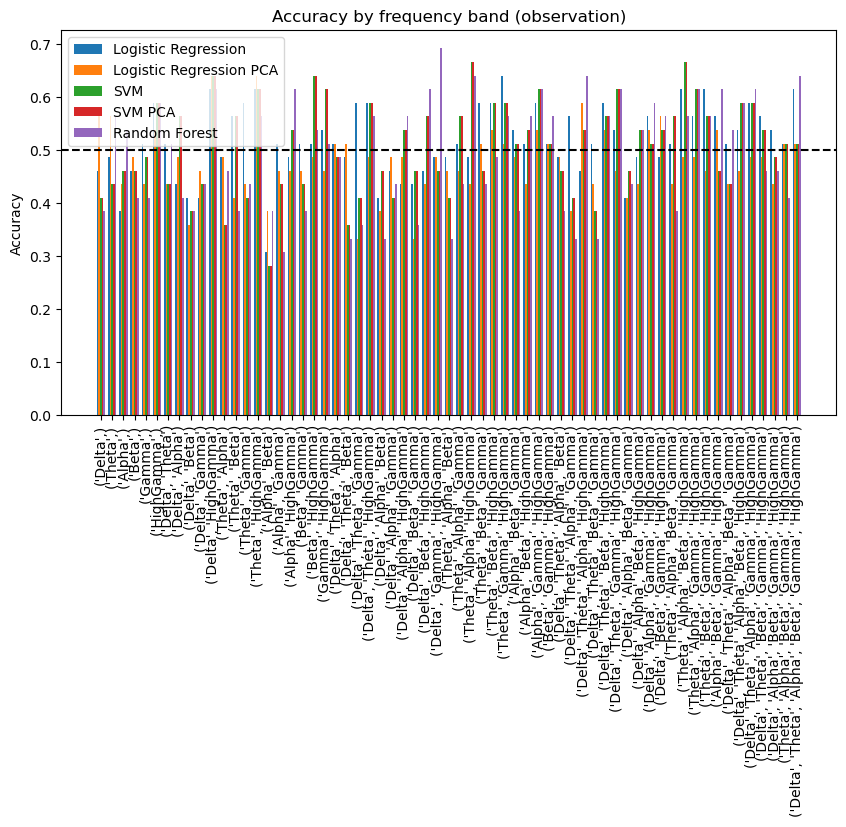

In [8]:
width = 0.15
ind = np.arange(len(freq_powerset))

plt.figure(figsize=(10,5))
plt.bar(ind, logreg_accuracies, width, label='Logistic Regression')
plt.bar(ind + width, logreg_pca_accuracies, width, label='Logistic Regression PCA')
plt.bar(ind + 2*width, svm_accuracies, width, label='SVM')
plt.bar(ind + 3*width, svm_accuracies, width, label='SVM PCA')
plt.bar(ind + 4*width, rf_accuracies, width, label='Random Forest')
plt.xticks(ind + 2*width, freq_powerset, rotation=90)
plt.axhline(0.5, linestyle='--', color='k')
plt.legend()
plt.ylabel('Accuracy')
plt.title('Accuracy by frequency band (observation)')
plt.show()